**Import Libraries**

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from keras.layers import Layer
import tensorflow as tf

import warnings
warnings.simplefilter('ignore', FutureWarning)

### **Step 1: Data Preparation**
We start by define the sentences and text for translation training
Sentence Pairs: Defines a small dataset of English-Spanish sentence pairs.
Target Sequences:
Prepends "startseq" and appends "endseq" to each target sentence for the decoder to learn when to start and stop translating.


In [15]:
input_texts = [
    "Hello.", "How are you?", "I am learning machine translation.", "What is your name?", "I love programming."
]
target_texts = [
    "Hola.", "¿Cómo estás?", "Estoy aprendiendo traducción automática.", "¿Cuál es tu nombre?", "Me encanta programar."
]

target_texts = ["startseq " + x + " endseq" for x in target_texts]
target_texts

['startseq Hola. endseq',
 'startseq ¿Cómo estás? endseq',
 'startseq Estoy aprendiendo traducción automática. endseq',
 'startseq ¿Cuál es tu nombre? endseq',
 'startseq Me encanta programar. endseq']

### **Next, we convert the text from the sentences to tokens and create a vocabulary**
Tokenization: Uses Tokenizer to convert words into numerical sequences.


In [16]:
# Input Text Tokenization
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(input_texts)
input_sequence = input_tokenizer.texts_to_sequences(input_texts)
print(f'Token Index: {input_tokenizer.word_index}') # Repeated word gets lowest index
print(f"Token Index to Sequence: {input_sequence}")

Token Index: {'i': 1, 'hello': 2, 'how': 3, 'are': 4, 'you': 5, 'am': 6, 'learning': 7, 'machine': 8, 'translation': 9, 'what': 10, 'is': 11, 'your': 12, 'name': 13, 'love': 14, 'programming': 15}
Token Index to Sequence: [[2], [3, 4, 5], [1, 6, 7, 8, 9], [10, 11, 12, 13], [1, 14, 15]]


In [17]:
# Output Text Tokenization
output_tokenizer = Tokenizer()
output_tokenizer.fit_on_texts(target_texts)
output_sequence = output_tokenizer.texts_to_sequences(target_texts)
print(f"Target Word Index: {output_tokenizer.word_counts}")
print(f"Target Word Index: {output_sequence}")

Target Word Index: OrderedDict([('startseq', 5), ('hola', 1), ('endseq', 5), ('¿cómo', 1), ('estás', 1), ('estoy', 1), ('aprendiendo', 1), ('traducción', 1), ('automática', 1), ('¿cuál', 1), ('es', 1), ('tu', 1), ('nombre', 1), ('me', 1), ('encanta', 1), ('programar', 1)])
Target Word Index: [[1, 3, 2], [1, 4, 5, 2], [1, 6, 7, 8, 9, 2], [1, 10, 11, 12, 13, 2], [1, 14, 15, 16, 2]]


In [18]:
input_vocab_size = len(input_tokenizer.word_index)+1
output_vocab_size = len(output_tokenizer.word_index)+1

### **Now pad the corresponding sentences**
Padding: Ensures all sequences have the same length.


In [19]:
# Padding
max_input_length = max([len(seq) for seq in input_sequence])
max_output_length = max([len(seq) for seq in output_sequence])

# Lets add padding
input_sequence = pad_sequences(input_sequence, maxlen = max_input_length, padding = 'post')
output_sequence = pad_sequences(output_sequence, maxlen = max_output_length, padding = 'post')

# Prepare the target data for training
decoder_input_data = output_sequence[:, :-1]
decoder_output_data = output_sequence[:, 1:]

# Convert to one-hot
decoder_output_data = np.array([np.eye(output_vocab_size)[seq] for seq in decoder_output_data])

### **Self-Attention Layer**
Self-attention is a mechanism that allows a model to **focus on relevant parts of the input sequence** while processing each word. This is particularly useful in:
1) Machine Translation (e.g., aligning words correctly)
2) Text Summarization
3) Speech Recognition
4) Image Processing (Vision Transformers)
In this implementation, self-attention is used for text based sequence-to-sequence modeling.


Self-Attention works for a given an input sequence by computing a weighted representation of all words for each position. It does so using three key components:

1. Query **(Q)**, Key **(K)**, and Value **(V)** Matrices
For each word (token) in a sequence:

Query (Q): What this word is looking for.
Key (K): What this word represents.
Value (V): The actual information in the word.

2. Compute **Attention Scores**
Next, we **calculate the similarity between each query and key** using dot-product attention:
Each word in a sequence attends to every other word based on these scores.

3. Apply **Scaling & Softmax**
Since dot-product values can be large, we scale them. 
Next, Applying softmax converts scores into attention weights:


### Self-Attention class
In this implementation of self-attention layer:
1. We first initialize the weights in the **build** method, where:
    1. **self.Wq**, **self.Wk**, **self.Wv** are the trainable weight matrices.
    2. Their **shape is (feature_dim, feature_dim)**, meaning they transform input features into Q, K, and V representations.
2. Applying Attention using **call** method. The **call()** method:
   1. Computes **Q, K, V** by multiplying inputs (encoder/decoder output) with their respective weight matrices.
   2. Computes **dot-product attention scores** using K.batch_dot(q, k, axes=[2, 2]), resulting in a (batch_size, seq_len, seq_len) matrix.
   3. **Scales** the scores to avoid large values.
   4. Applies **softmax** to normalize the attention scores.
   5. **Multiplies attention weights with V** to get the final output.
3. The **compute_output_shape** method defines the shape of the output tensor after the layer processes an input.
    1. The output shape of the Self-Attention layer **remains the same** as the input shape.
    2. The attention mechanism **transforms** the input but does not change its dimensions.4
    3. If the attention layer changed the shape, you would modify compute_output_shape


In [20]:
# Define self-attention layer using class inheritance
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        feature_dim = input_shape[-1]

        # Weight matrices for Q, K, V
        self.Wq = self.add_weight(shape=(feature_dim, feature_dim),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name='Wq')
        self.Wk = self.add_weight(name='Wk',
                                  trainable=True,
                                  shape=(feature_dim, feature_dim), 
                                  initializer='glorot_uniform')
        self.Wv = self.add_weight(name='Wv', 
                                  trainable=True,
                                  shape=(feature_dim, feature_dim),
                                  initializer='glorot_uniform')
        
        super(SelfAttention, self).build(input_shape)
    
    def call(self, inputs):
        q = K.dot(inputs, self.Wq)  # Query
        k = K.dot(inputs, self.Wk)  # Key
        v = K.dot(inputs, self.Wv)  # Value

        # Scaled Dot-Product Attention
        scores = K.batch_dot(q, k, axes=[2, 2]) # (batch, seq_len, seq_len)
        scores = scores/K.sqrt(K.cast(K.shape(k)[-1], dtype=K.floatx()))    # Scale
        attention_weights = K.softmax(scores, axis=-1)  # Normalize

        # Weighted sum of values
        output = K.batch_dot(attention_weights, v)

        return output
    
    def compute_output_shape(self, input_shape):
        return input_shape

### **Model Architecture**
The model follows an Encoder-Decoder structure:

### Encoder:
1) Takes input sentences (padded and tokenized).
2) Uses an Embedding layer (word representations) + LSTM (to process sequences).
    1. The LSTMs are used as the **help process variable-length input sentences** and generate meaningful translations.
4) Outputs context vectors (hidden & cell states).

### Attention Layer
1) Applied to both the encoder and decoder outputs.
2) Helps the decoder focus on relevant words during translation.

### Decoder
1) Receives target sequences (shifted one step ahead).
2) Uses an LSTM with encoder states as initial states.
3) Applies self-attention for better learning.
4) Uses a Dense layer (Softmax) to predict the next word.


In [21]:
# Encoder
encoder_inputs = Input(shape=(max_input_length, ))
encoder_embedding = Embedding(input_vocab_size, 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_state = [state_h, state_c]

# Self-attention Mechanism
attention_layer = SelfAttention()(encoder_outputs)

# Decoder
decoder_inputs = Input(shape=(max_output_length-1))
decoder_embedding = Embedding(output_vocab_size, 256)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_state)
decoder_attention = SelfAttention()(decoder_outputs)    # Apply attention
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_attention)

# Full model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 5, 256)               4096      ['input_5[0][0]']             
                                                                                                  
 embedding_5 (Embedding)     (None, 5, 256)               4352      ['input_6[0][0]']             
                                                                                            

### **Training Model**

In [22]:
final_result = model.fit([input_sequence, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 2.8346 - accuracy: 0.0400
Epoch 2/100
1/1 [==============================] - 0s 23ms/step - loss: 2.8028 - accuracy: 0.3200
Epoch 3/100
1/1 [==============================] - 0s 21ms/step - loss: 2.7663 - accuracy: 0.2800
Epoch 4/100
1/1 [==============================] - 0s 21ms/step - loss: 2.7176 - accuracy: 0.2800
Epoch 5/100
1/1 [==============================] - 0s 21ms/step - loss: 2.6492 - accuracy: 0.2400
Epoch 6/100
1/1 [==============================] - 0s 22ms/step - loss: 2.5547 - accuracy: 0.2400
Epoch 7/100
1/1 [==============================] - 0s 21ms/step - loss: 2.4376 - accuracy: 0.2400
Epoch 8/100
1/1 [==============================] - 0s 21ms/step - loss: 2.3468 - accuracy: 0.2400
Epoch 9/100
1/1 [==============================] - 0s 22ms/step - loss: 2.3827 - accuracy: 0.2400
Epoch 10/100
1/1 [==============================] - 0s 22ms/step - loss: 2.3421 - accuracy: 0.2800
Epoch 11/100
1/1 [===

### **Plotting Training Loss**

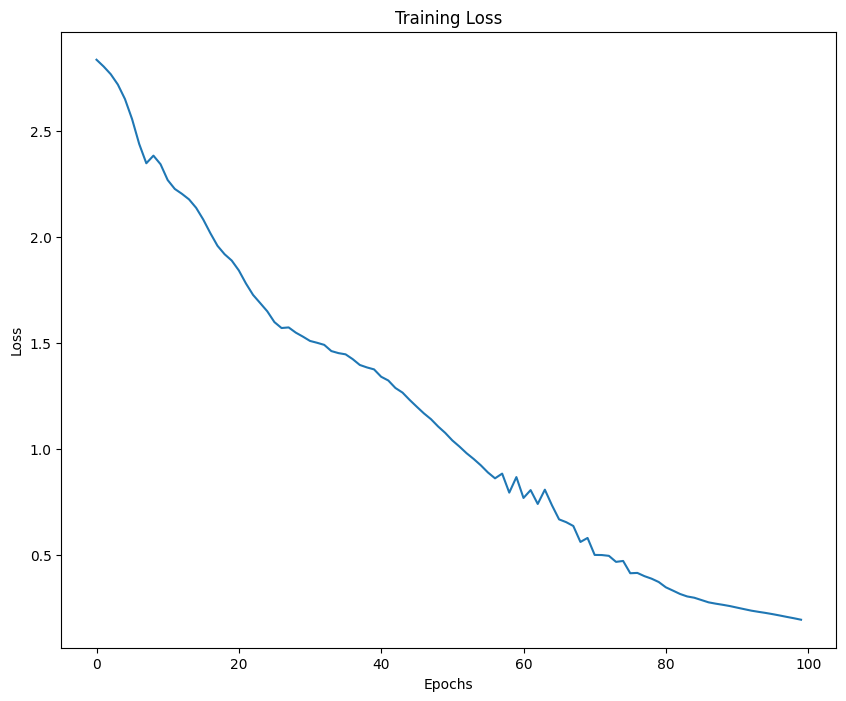

In [23]:
plt.figure(figsize=(10, 8))
plt.plot(final_result.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# **Lets try with different *Initializer: he_uniform***

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 2.8357 - accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 26ms/step - loss: 2.7899 - accuracy: 0.3200
Epoch 3/100
1/1 [==============================] - 0s 21ms/step - loss: 2.7392 - accuracy: 0.2800
Epoch 4/100
1/1 [==============================] - 0s 21ms/step - loss: 2.6740 - accuracy: 0.2800
Epoch 5/100
1/1 [==============================] - 0s 21ms/step - loss: 2.5860 - accuracy: 0.2800
Epoch 6/100
1/1 [==============================] - 0s 20ms/step - loss: 2.4713 - accuracy: 0.2800
Epoch 7/100
1/1 [==============================] - 0s 21ms/step - loss: 2.3468 - accuracy: 0.2800
Epoch 8/100
1/1 [==============================] - 0s 21ms/step - loss: 2.2962 - accuracy: 0.2800
Epoch 9/100
1/1 [==============================] - 0s 51ms/step - loss: 2.2995 - accuracy: 0.2800
Epoch 10/100
1/1 [==============================] - 0s 21ms/step - loss: 2.2239 - accuracy: 0.3200
Epoch 11/100
1/1 

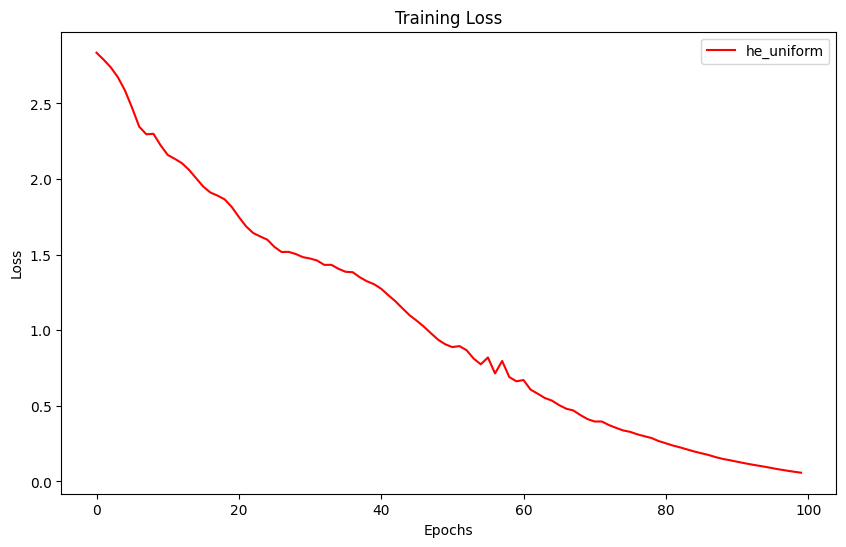

In [24]:
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        self.Wq = self.add_weight(shape=(feature_dim, feature_dim), initializer='he_uniform', trainable=True)
        self.Wk = self.add_weight(shape=(feature_dim, feature_dim), initializer='he_uniform', trainable=True)
        self.Wv = self.add_weight(shape=(feature_dim, feature_dim), initializer='he_uniform', trainable=True)
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        q = K.dot(inputs, self.Wq)
        k = K.dot(inputs, self.Wk)
        v = K.dot(inputs, self.Wv)

        scores = K.batch_dot(q, k, axes=[2, 2])
        scores = scores/K.sqrt(K.cast(K.shape(k)[-1], dtype=K.floatx()))
        attention_weight = K.softmax(scores, axis=-1)

        output = K.batch_dot(attention_weight, v)
        return output
    
    def compute_output_shape(self, input_shape):
        return input_shape
    
# Encoder 
encoder_input = Input(shape=(max_input_length, ))
encoder_embedding = Embedding(input_vocab_size, 256)(encoder_input)
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_output, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_state = [state_h, state_c]

attention_layer = SelfAttention()(encoder_output)

# Decoder 
decoder_input = Input(shape=(max_output_length-1, ))
decoder_embedding = Embedding(output_vocab_size, 256)(decoder_input)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_state)
decoder_attention = SelfAttention()(decoder_outputs)
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_attention)

# Full model
model = Model([encoder_input, decoder_input], decoder_outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

final_model_he = model.fit([input_sequence, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)
# Plotting data
plt.figure(figsize=(10, 6))
plt.plot(final_model_he.history['loss'], label='he_uniform', color='red')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### **Use of Adaptive Gradient *(adagrad)* instead of *adam***

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 2.1571e-04 - accuracy: 1.0000
Epoch 2/100
1/1 [==============================] - 0s 25ms/step - loss: 1.7809e-04 - accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - 0s 22ms/step - loss: 2.1171e-04 - accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 23ms/step - loss: 6.4046e-04 - accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 22ms/step - loss: 2.6282e-04 - accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 25ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 24ms/step - loss: 2.7141e-04 - accuracy: 1.0000
Epoch 8/100
1/1 [==============================] - 0s 24ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 9/100
1/1 [==============================] - 0s 21ms/step - loss: 2.3190e-04 - accuracy: 1.0000
Epoch 10/100
1/1 [==============================] - 0s 24ms/step - loss: 0.0068 - accuracy: 

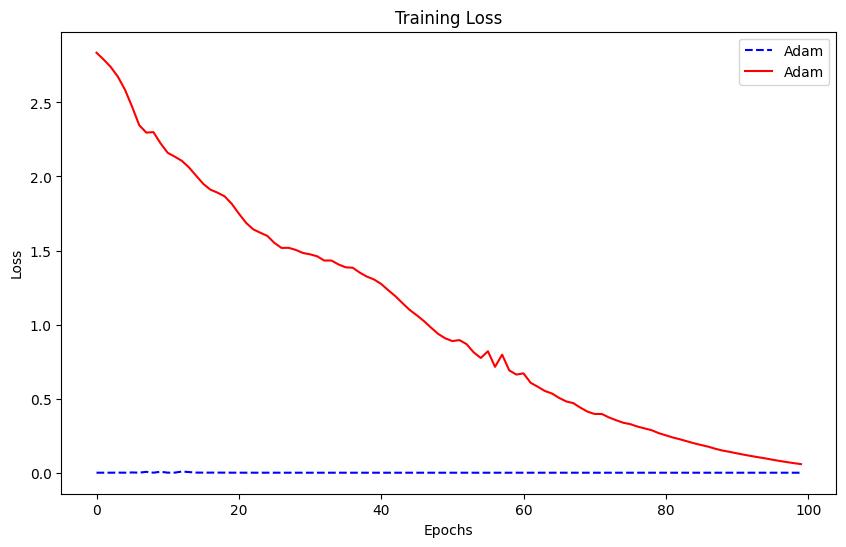

In [31]:
model = Model([encoder_input, decoder_input], decoder_outputs)
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
final_result_adagrad = model.fit([input_sequence, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

plt.figure(figsize=(10, 6))
plt.plot(final_result_adagrad.history['loss'], label='Adam', color='blue', ls='--')
plt.plot(final_model_he.history['loss'], label='Adam', color='red')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()